In [1]:
%pylab inline
import magproc.magdata
import magproc.pipeline
import magproc.plots
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
d = magproc.magdata.MagData.load("../2025-07-14 mag_qc_dev/data/full_test_data.csv", crs=32604)

In [3]:
d

crs: 32604
filename: full_test_data.csv
sample_frequency: 40.000000009313226


                     count          mean           std           min           25%           50%           75%           max
Date      247882.0  2.023721e+03      0.006817  2.023715e+03  2.023715e+03  2.023715e+03  2.023729e+03  2.023729e+03
DEMIFSAR  247882.0  4.075875e+02    162.649756  1.202800e+02  3.041200e+02  3.721900e+02  4.798100e+02  1.330590e+03
Diurnal   247882.0  5.515270e+04     28.575697  5.509173e+04  5.512978e+04  5.515686e+04  5.516484e+04  5.520381e+04
Easting   247882.0  6.986166e+05  32364.958619  6.399358e+05  6.707023e+05  7.019343e+05  7.240310e+05  7.591394e+05
GPSALT    247882.0  6.133577e+02    209.974463  2.623400e+02  4.724000e+02  5.671500e+02  6.944775e+02  1.599090e+03
MAGUNCOM  247882.0  5.550192e+04     62.121445  5.534899e+04  5.546006e+04  5.548458e+04  5.553544e+04  5.589800e+04
UTCTIME   247882.0  7.743510e+04   8789.327998  6.395966e+04  6.550900e+04  8.300278e+04  8.39

/home/redhog/Projects/AGF-GeoPhysics/OM_DGGS_python_extensions/magproc/magdata.py:90: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  ax = gdf.plot(**kw)


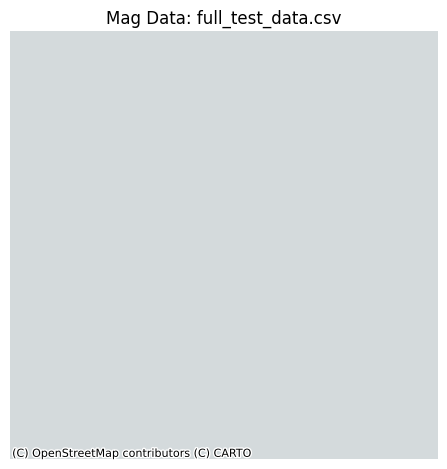

<Axes: title={'center': 'Mag Data: full_test_data.csv'}>

In [4]:
d.plot_map(markersize=1, zoom=12, column="MAGCOM")

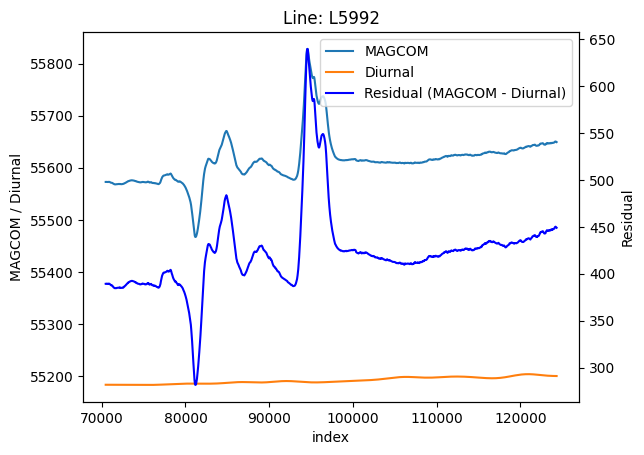

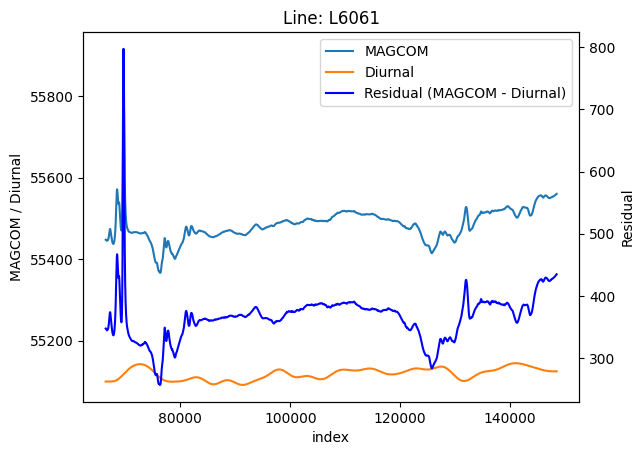

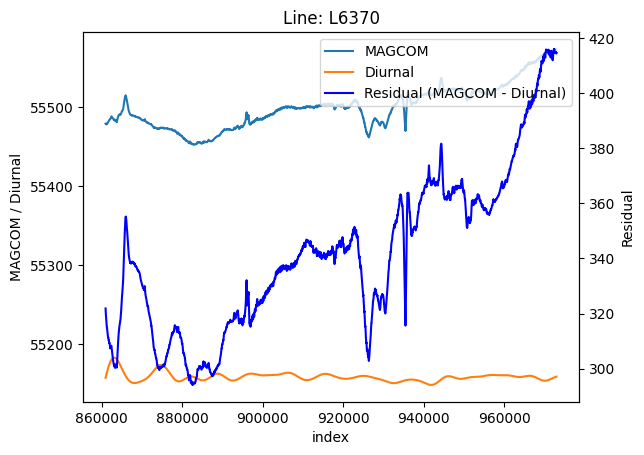

In [5]:
d.plot()

In [6]:
d.save("foo.mag.zip")

In [7]:
p = magproc.pipeline.MagPipeline.parse("""
steps:
 - set_meta:
     crs: 32604
     diurnal:
       lat: 62.9588417 
       lon: -155.599325
 - surface_error
 - elevation
 - set_constants
 - downline_distance
 - lowpass_filter_butterworth:
     cutoff_freq: 0.01 # Hz, note max at the nyquist freq at sample rate 40Hz / 2
 - highpass_filter_butterworth:
     cutoff_freq: 1.0 # Hz, note max at the nyquist freq at sample rate 40Hz / 2
     column_out: hf_noise
 - diurnal_qc_for_15s_chord
 - diurnal_qc_for_60s_chord
 - drape_and_speed_qc
 - noice_qc:
     MAG_4th_diff_OOS_threshold: 0.05
 - write_noise_summary
 - write_diurnal_summary
 - write_drape_summary
""", out_path="../testout")


In [8]:
os.makedirs(p.pipeline["out_path"], exist_ok=True)
dp = p.run(d)

Running step 0: set_meta with crs=32604, diurnal={'lat': 62.9588417, 'lon': -155.599325}
Running step 1: surface_error
Running step 2: elevation
Running step 3: set_constants
Running step 4: downline_distance
Running step 5: lowpass_filter_butterworth with cutoff_freq=0.01
Running step 6: highpass_filter_butterworth with cutoff_freq=1.0, column_out=hf_noise
Running step 7: diurnal_qc_for_15s_chord
Running step 8: diurnal_qc_for_60s_chord
Running step 9: drape_and_speed_qc
Running step 10: noice_qc with MAG_4th_diff_OOS_threshold=0.05
Running step 11: write_noise_summary
Running step 12: write_diurnal_summary
Running step 13: write_drape_summary


/home/redhog/Projects/AGF-GeoPhysics/OM_DGGS_python_extensions/magproc/magfilters.py:415: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  drape_summary = pd.concat([drape_summary, OOS_drape], ignore_index=True) # add OOS drape segments to summary dataframe


In [9]:
dp.save("output.mag.zip")

In [10]:
dp

crs: 32604
diurnal:
  lat: 62.9588417
  lon: -155.599325
filename: full_test_data.csv
sample_frequency: 40.000000009313226


                                     count          mean           std           min           25%           50%           75%           max
Date                      247882.0  2.023721e+03  6.817273e-03  2.023715e+03  2.023715e+03  2.023715e+03  2.023729e+03  2.023729e+03
DEMIFSAR                  247882.0  4.075875e+02  1.626498e+02  1.202800e+02  3.041200e+02  3.721900e+02  4.798100e+02  1.330590e+03
Diurnal                   247882.0  5.515270e+04  2.857570e+01  5.509173e+04  5.512978e+04  5.515686e+04  5.516484e+04  5.520381e+04
Easting                   247882.0  6.986166e+05  3.236496e+04  6.399358e+05  6.707023e+05  7.019343e+05  7.240310e+05  7.591394e+05
GPSALT                    247882.0  6.133577e+02  2.099745e+02  2.623400e+02  4.724000e+02  5.671500e+02  6.944775e+02  1.599090e+03
MAGUNCOM                  247882.0  5.550192e+04  6.212145e+01  5.534

In [36]:
import importlib
importlib.reload(magproc.plots)
importlib.reload(magproc.magdata)

dp = magproc.magdata.MagData(dp.data, **dp.meta)

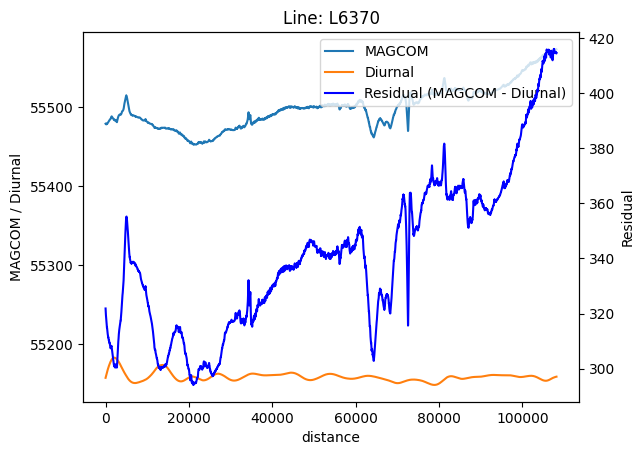

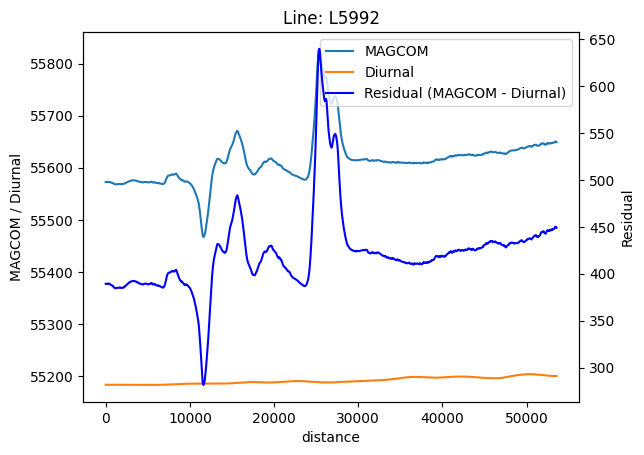

In [27]:
dp.plot_lines(
    magproc.plots.plot_line,
    lines=["L6370", "L5992"], # Only plot these lines
    xcolumn="distance") # You can plot against any column, e.g. distance, UTCTIME, or "index" (FIDCOUNT).

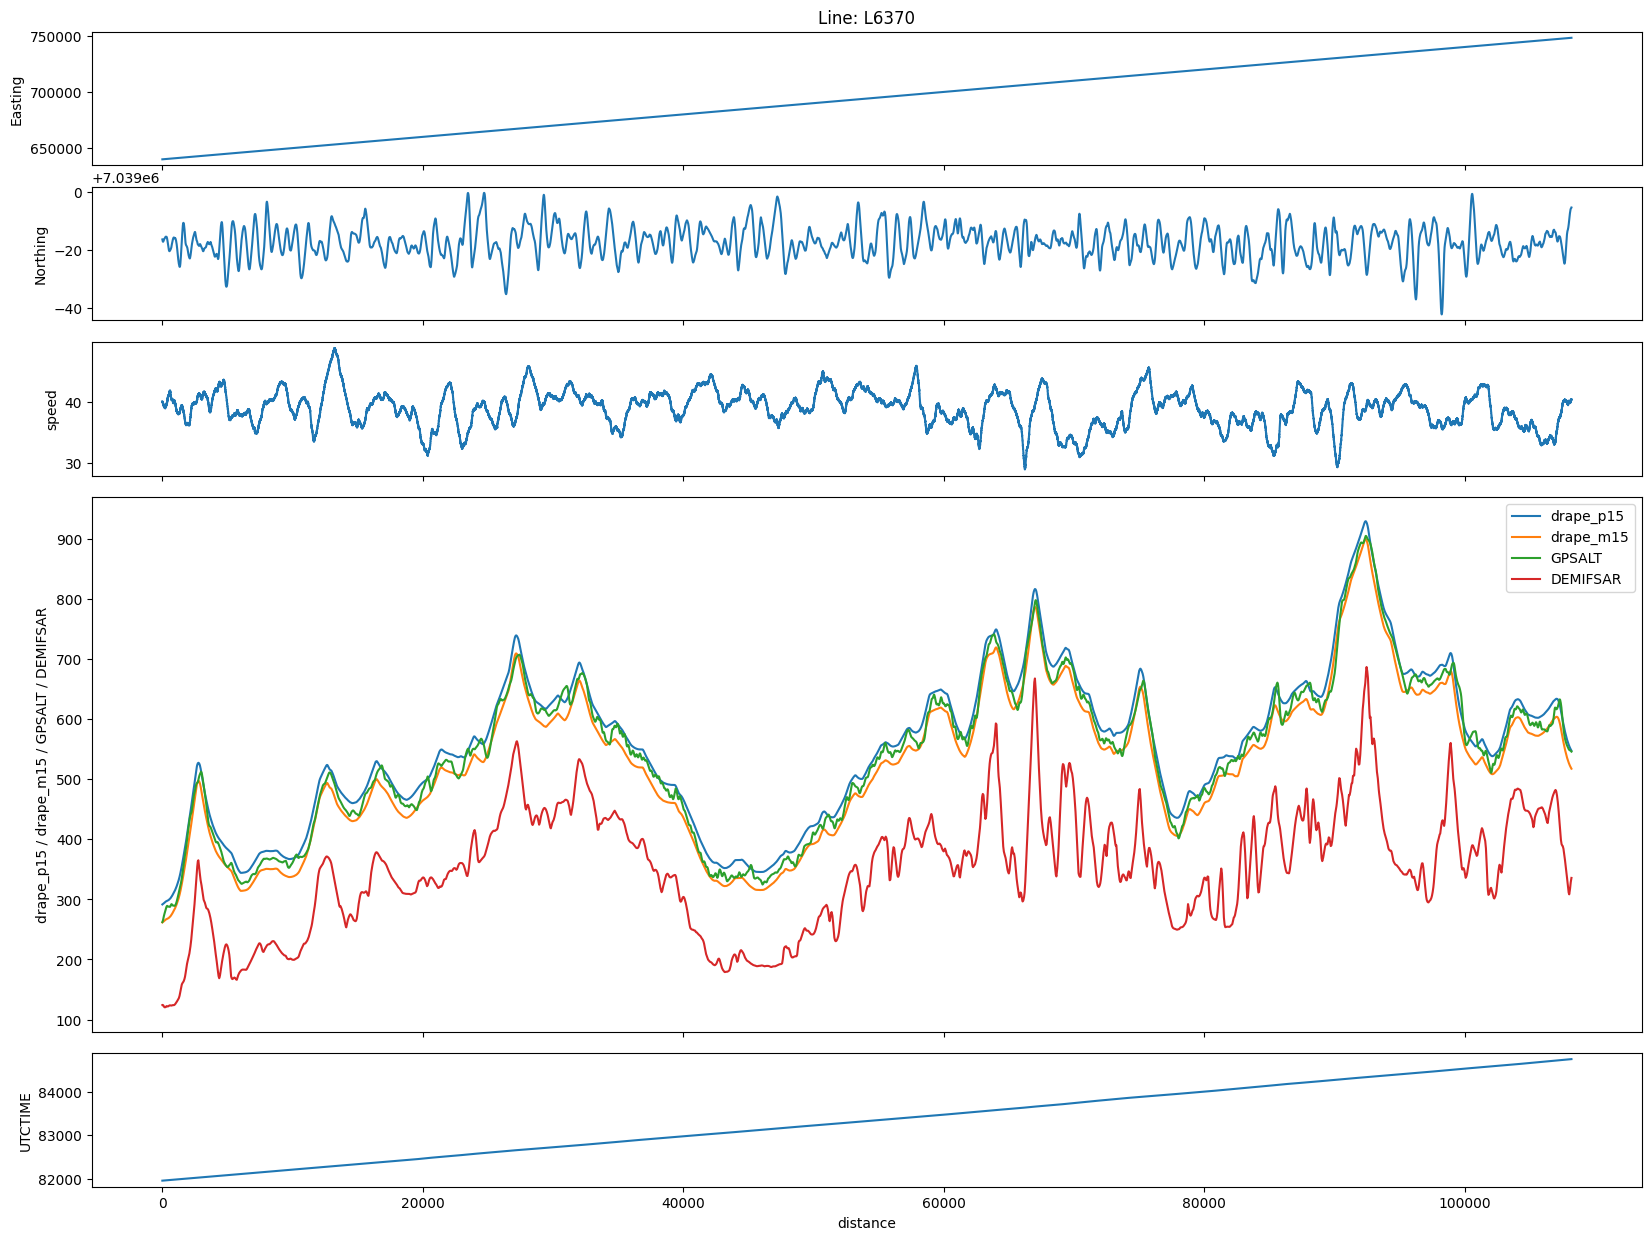

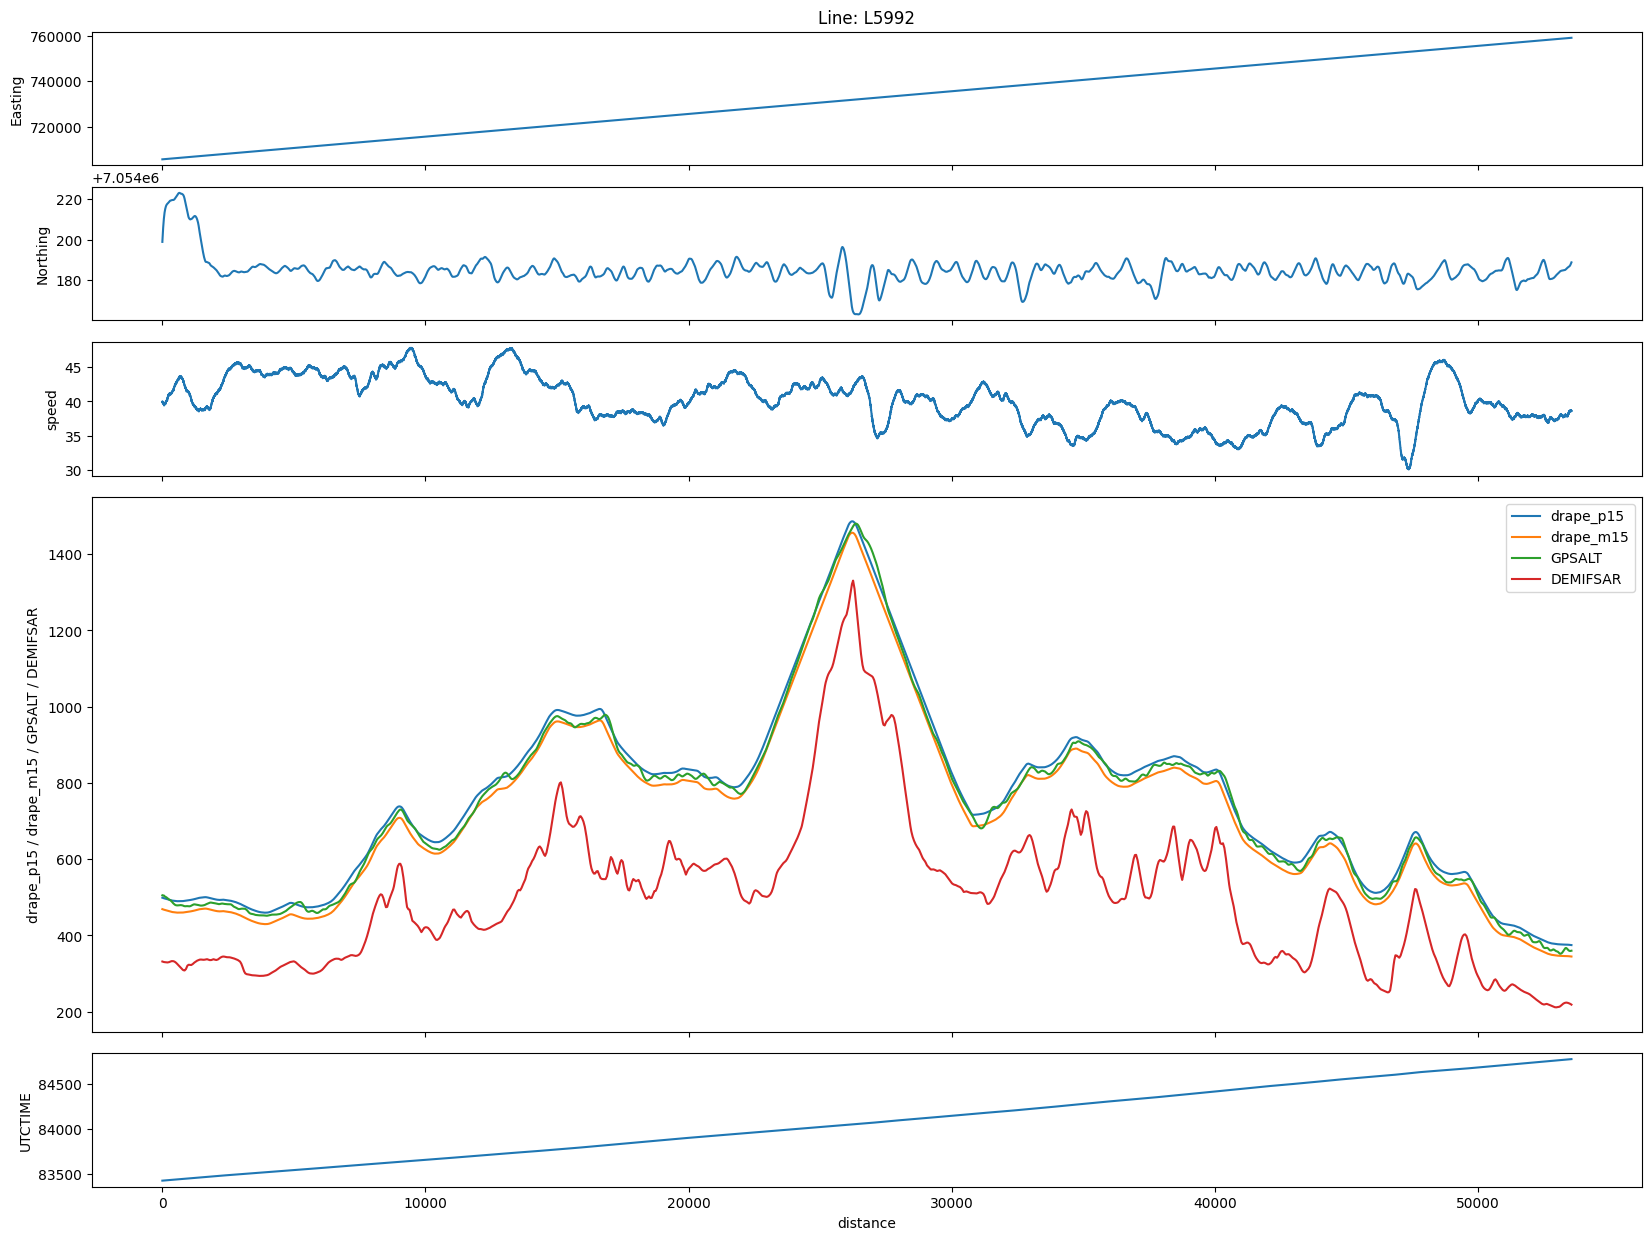

In [24]:
dp.plot_lines(
    magproc.plots.plot_drape_qc,
    lines=["L6370", "L5992"], # Only plot these lines
    xcolumn="distance") # You can plot against any column, e.g. distance, UTCTIME, or "index" (FIDCOUNT).

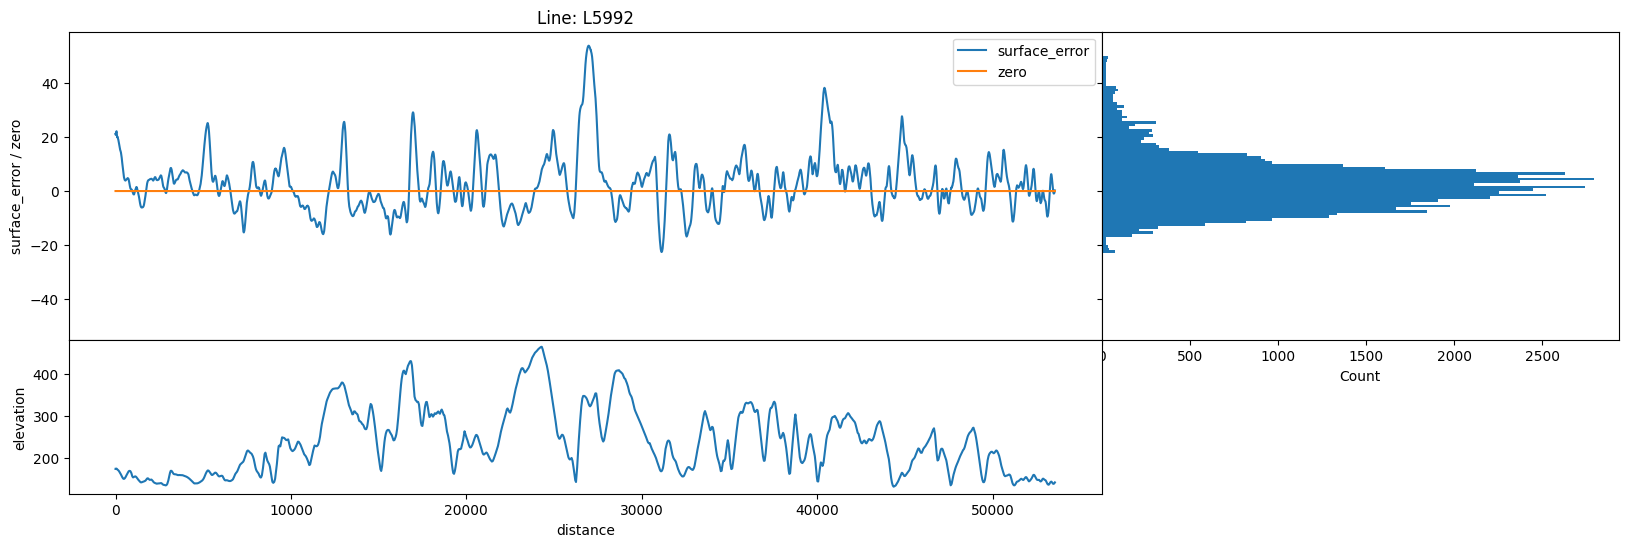

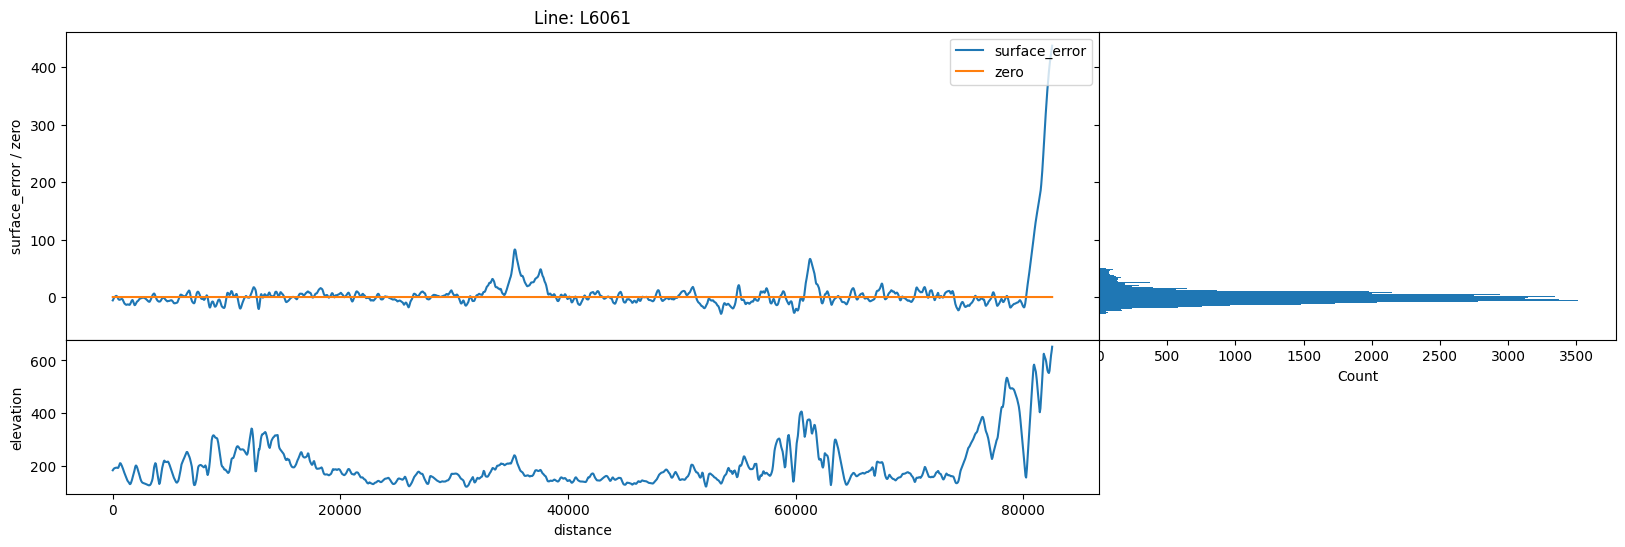

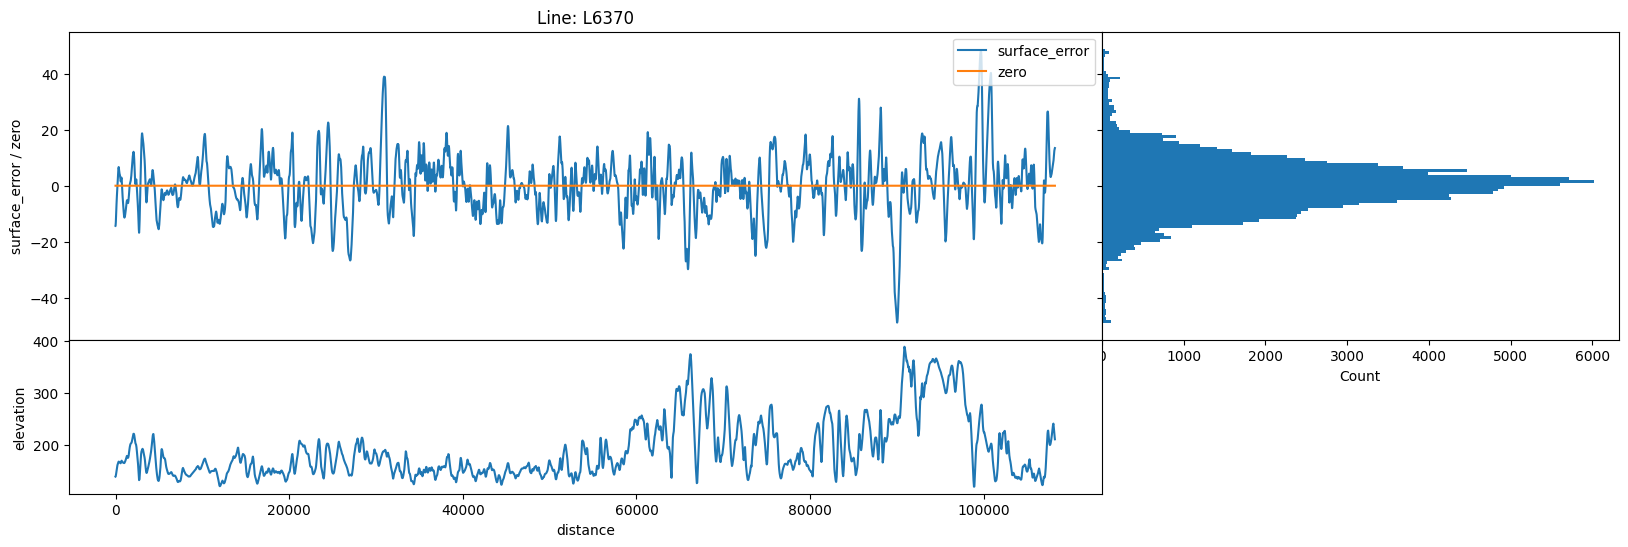

In [37]:
dp.plot_lines(
    magproc.plots.plot_drape_qc2,
    xcolumn="distance") # You can plot against any column, e.g. distance, UTCTIME, or "index" (FIDCOUNT).

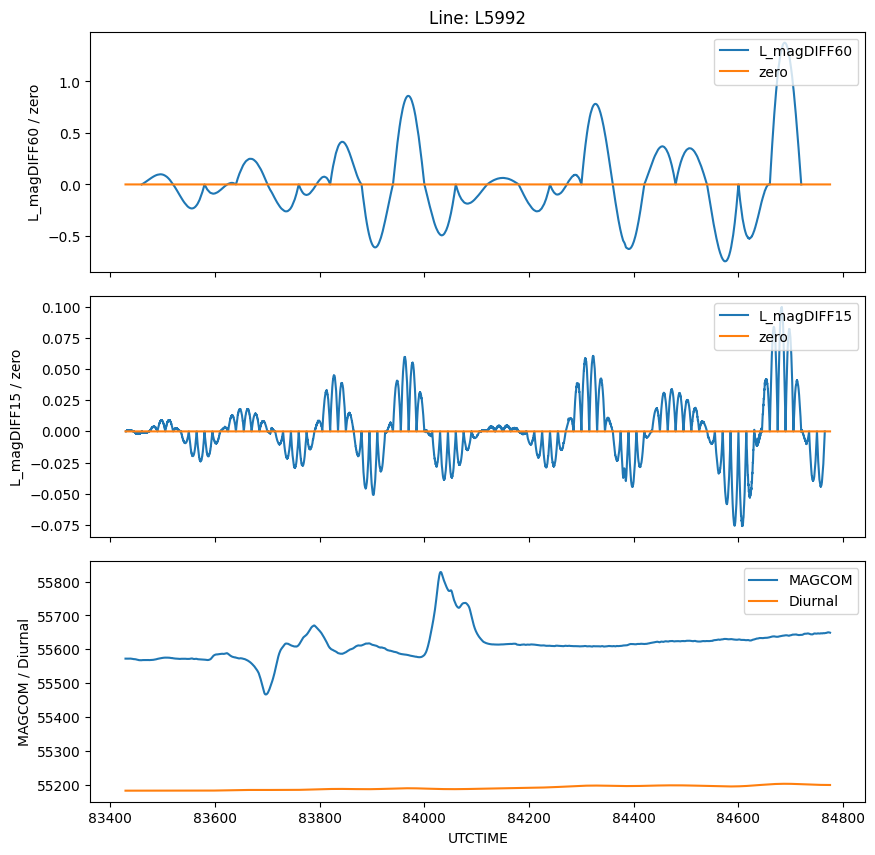

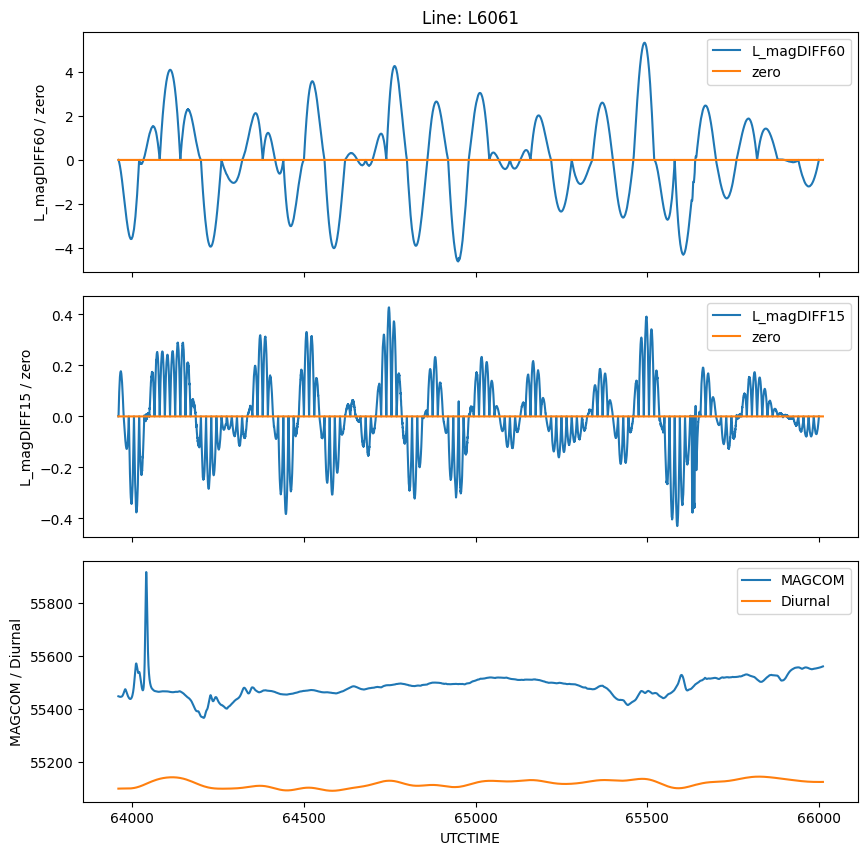

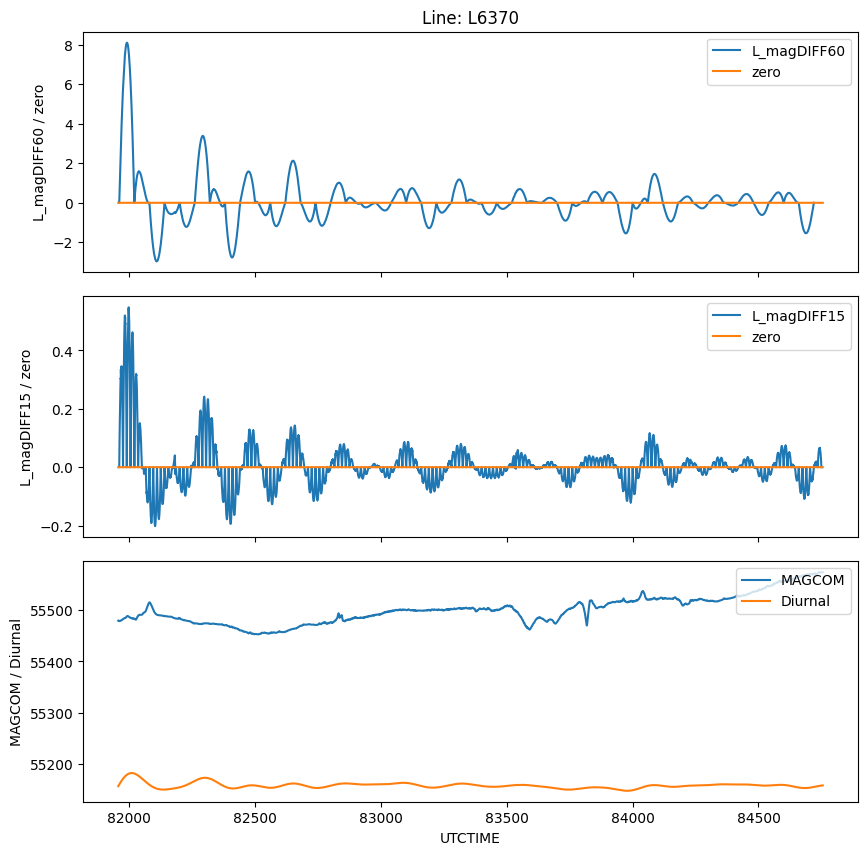

In [14]:
dp.plot_lines(
    magproc.plots.plot_diurnal_qc,
    xcolumn="UTCTIME") # You can plot against any column, e.g. distance, UTCTIME, or "index" (FIDCOUNT).

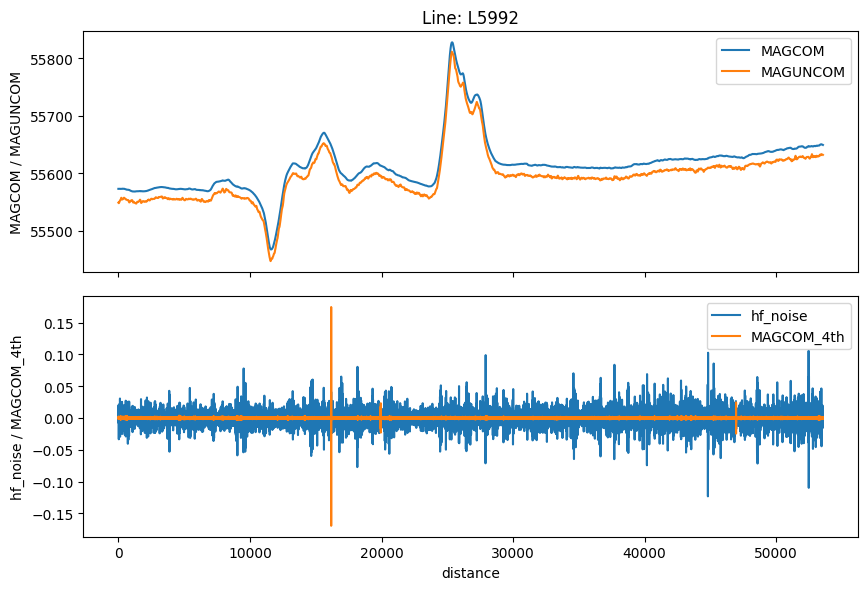

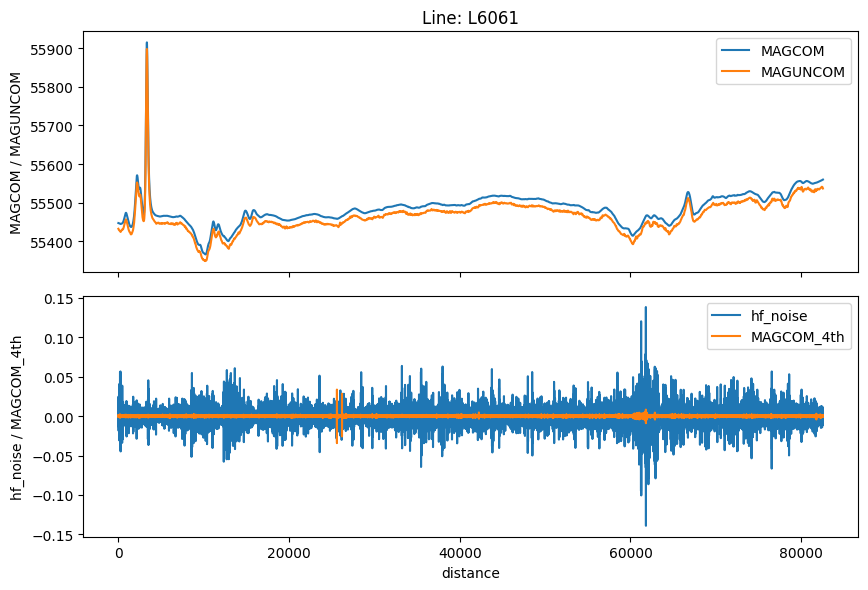

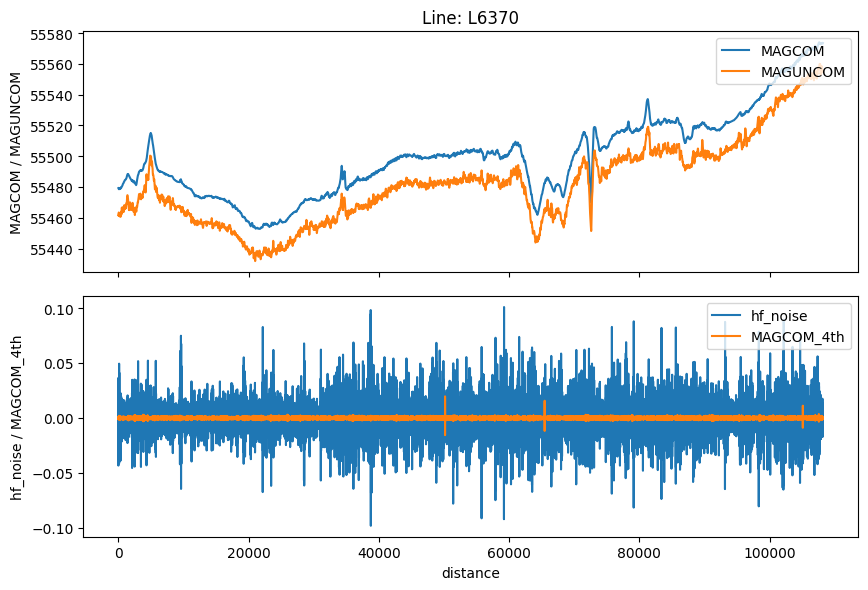

In [15]:
dp.plot_lines(
    magproc.plots.plot_hf_noise_qc,
    xcolumn="distance") # You can plot against any column, e.g. distance, UTCTIME, or "index" (FIDCOUNT).